In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shap

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_consumo = pd.read_csv('data.csv')
df_consumo

,date,state,stateMessages,volume,logDate,logVolume,deltaVolumes,error,device_name,dev_eui,dev_addr
0,2023-04-03T08:25:45,0,OK,1.221 m3,2023-04-02T17:00:00,1.201 m3,"0.007 m3,0.013 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,...",NaN,5847811,8c83fc0500593b03,015307ae
1,2023-04-03T08:25:22,0,OK,0.832 m3,2023-04-02T17:00:00,0.832 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002186,8c83fc05005b960a,01f35e1e
2,2023-04-03T08:26:45,0,OK,0.843 m3,2023-04-02T17:00:00,0.842 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002183,8c83fc05005b9607,01cd1fd4
3,2023-04-03T08:26:48,0,OK,2.965 m3,2023-04-02T17:00:00,1.058 m3,"0.797 m3,0.864 m3,0.243 m3,0.0 m3,0.0 m3,0.0 m...",NaN,06154373,8c83fc05005de885,005384e4
4,2023-04-03T08:34:43,0,OK,2.631 m3,2023-04-02T17:00:00,2.618 m3,"0.012 m3,0.001 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,...",NaN,5846673,8c83fc0500593691,00bf9cee
...,...,...,...,...,...,...,...,...,...,...,...
69638,2023-07-18T13:59:06,0,OK,1.223 m3,2023-07-17T22:00:00,1.223 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002200,8c83fc05005b9618,0048b15e
69639,2023-07-18T13:59:45,0,OK,6.223 m3,2023-07-17T22:00:00,6.164 m3,"0.003 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.004 m3,...",NaN,6002437,8c83fc05005b9705,00729354
69640,2023-07-18T14:02:26,0,OK,0.799 m3,2023-07-17T23:00:00,0.797 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002488,8c83fc05005b9738,00186f5c
69641,2023-07-18T14:06:47,0,OK,55.465 m3,2023-07-17T23:00:00,55.419 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,5837027,8c83fc05005910e3,01164711


In [3]:
df_consumo['date'] = pd.to_datetime(df_consumo['date'])
df_consumo = df_consumo[df_consumo['date'].dt.year == 2023]
df_consumo = df_consumo.sort_values(by='date')

In [4]:
df_temp = pd.read_json('temperaturas.json', orient='records')
df_temp

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2023-04-03,3469A,CÁCERES,CACERES,394,"13,0","0,0","4,2",06:00,"21,9",15:00,35,"1,4","6,4",13:35,"11,3","976,0",00,"965,4",23
1,2023-04-04,3469A,CÁCERES,CACERES,394,"16,9","0,0","9,7",06:30,"24,1",15:50,4,"2,5","9,2",11:21,"11,7","970,5",24,"964,8",04
2,2023-04-05,3469A,CÁCERES,CACERES,394,"15,1","0,0","6,4",06:10,"23,8",15:40,2,"2,8","6,7",14:37,"12,3","972,2",10,"968,9",16
3,2023-04-06,3469A,CÁCERES,CACERES,394,"16,4","0,0","6,9",06:20,"25,8",17:00,35,"1,9","6,4",17:00,"12,3","971,5",10,"968,8",Varias
4,2023-04-07,3469A,CÁCERES,CACERES,394,"16,8","0,0","7,1",06:10,"26,6",15:50,18,"1,4","7,5",23:58,"12,4","970,8",10,"967,8",17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-07-10,3469A,CÁCERES,CACERES,394,"29,6","0,0","19,0",05:00,"40,1",16:10,28,"1,7","9,7",15:30,"14,2","974,7",08,"970,1",20
99,2023-07-11,3469A,CÁCERES,CACERES,394,"30,0","0,0","22,5",05:30,"37,6",15:30,22,"3,3","11,9",16:20,"14,0","971,6",23,"969,3",17
100,2023-07-12,3469A,CÁCERES,CACERES,394,"26,5","0,0","19,0",05:00,"34,0",15:30,26,"3,1","9,2",17:00,"13,4","973,0",Varias,"970,6",02
101,2023-07-13,3469A,CÁCERES,CACERES,394,"28,4","0,0","20,9",05:10,"35,9",16:30,31,"2,8","8,1",15:15,"14,3","974,1",08,"970,4",19


In [5]:
df_consumo = df_consumo[df_consumo['date'].dt.year == datetime.now().year]
df_consumo = df_consumo.sort_values(by='date')

In [6]:
df_consumo = df_consumo.rename(columns={'volume': 'volumem3'})
df_consumo['volumem3'] = df_consumo['volumem3'].str.replace(' m3', '').astype(float)
df_consumo = df_consumo.rename(columns={'logVolume': 'logVolumem3'})
df_consumo['logVolumem3'] = df_consumo['logVolumem3'].str.replace(' m3', '').astype(float)

In [7]:
def clean_delta_volume(x):
    if isinstance(x, list):
        return [str(item).strip() for item in x]
    elif isinstance(x, str):
        return x.split(',')
    else:
        return [str(x)]

# Aplica la función 'clean_delta_volume' a cada elemento de la columna 'deltaVolumes'
df_consumo['deltaVolumes'] = df_consumo['deltaVolumes'].apply(clean_delta_volume)

# Calcula la longitud máxima de las listas en 'deltaVolumes'
max_length = df_consumo['deltaVolumes'].apply(len).max()
new_column_names = [f'deltaVolumes{i+1}cm3' for i in range(max_length)]
is_array = df_consumo['deltaVolumes'].apply(lambda x: isinstance(x, list))
df_consumo[new_column_names] = pd.DataFrame(df_consumo.loc[is_array, 'deltaVolumes'].values.tolist(), index=df_consumo.loc[is_array].index)

df_consumo[new_column_names] = df_consumo[new_column_names].apply(lambda x: x.str.replace(' m3', '').astype(float))
df_consumo.drop('deltaVolumes', axis=1, inplace=True)

In [8]:
df_consumo = df_consumo.drop(['state', 'stateMessages', 'error', 'logDate'], axis = 1)

In [9]:
# Crear un nuevo DataFrame vacío para almacenar los nuevos registros
new_df = pd.DataFrame(columns=['date', 'volumem3', 'logVolumem3', 'device_name', 'dev_eui', 'dev_addr', 'deltaVolumes'])

# Aplicar una función que crea los nuevos registros a partir de las columnas 'deltaVolumes'
def create_new_rows(row):
    # Obtener los valores de las columnas que se deben conservar
    date = row['date']
    volumem3 = row['volumem3']
    logVolumem3 = row['logVolumem3']
    device_name = row['device_name']
    dev_eui = row['dev_eui']
    dev_addr = row['dev_addr']
    
    # Crear una lista vacía para almacenar los nuevos registros
    new_rows = []
    
    # Iterar sobre las columnas 'deltaVolumes' en orden inverso
    for i in range(15, 7, -1):
        # Calcular la diferencia de horas respecto al registro original
        hour_diff = 1 + i
        
        # Crear un nuevo registro con los valores correspondientes
        new_row = {
            'date': date + pd.DateOffset(hours=hour_diff),
            'volumem3': volumem3,
            'logVolumem3': logVolumem3,
            'device_name': device_name,
            'dev_eui': dev_eui,
            'dev_addr': dev_addr,
            'deltaVolumes': row[f'deltaVolumes{i}cm3']
        }
        
        # Agregar el nuevo registro a la lista
        new_rows.append(new_row)
    
    # Devolver la lista de nuevos registros
    return new_rows

# Aplicar la función a cada fila del DataFrame original y obtener una lista de listas de nuevos registros
new_rows_list = df_consumo.apply(create_new_rows, axis=1)

# Convertir la lista de listas en una sola lista de nuevos registros
new_rows_list = [item for sublist in new_rows_list for item in sublist]

# Agregar los nuevos registros al DataFrame vacío
new_df = new_df.append(new_rows_list, ignore_index=True)

# Eliminar las columnas innecesarias del DataFrame original
df_consumo = df_consumo.drop(columns=[
    'deltaVolumes1cm3', 'deltaVolumes2cm3', 'deltaVolumes3cm3',
    'deltaVolumes4cm3', 'deltaVolumes5cm3', 'deltaVolumes6cm3',
    'deltaVolumes7cm3', 'deltaVolumes8cm3', 'deltaVolumes9cm3',
    'deltaVolumes10cm3', 'deltaVolumes11cm3', 'deltaVolumes12cm3',
    'deltaVolumes13cm3', 'deltaVolumes14cm3', 'deltaVolumes15cm3'
])

# Concatenar el DataFrame original con el nuevo DataFrame generado
df_consumo = pd.concat([df_consumo, new_df])

# Ordenar el DataFrame por fecha
df_consumo = df_consumo.sort_values('date')

# Restablecer los índices del DataFrame
df_consumo = df_consumo.dropna()
df_consumo = df_consumo.reset_index(drop=True)

In [10]:
# Eliminar las columnas 'volumem3' y 'logVolumem3'
df_consumo = df_consumo.drop(['volumem3', 'logVolumem3'], axis=1)

# Convertir la columna 'date' al formato de fecha adecuado
df_consumo['date'] = pd.to_datetime(df_consumo['date']).dt.date

# Sumar los valores de 'deltaVolumes' agrupados por 'device_name' y por día
df_con_sum = df_consumo.groupby(['date', 'device_name', 'dev_eui', 'dev_addr'])['deltaVolumes'].sum().reset_index()

# Imprimir el resultado
df_con_sum

,date,device_name,dev_eui,dev_addr,deltaVolumes
0,2023-04-03,05837043,8c83fc05005910f3,01ee74e6,0.000
1,2023-04-03,05837044,8c83fc05005910f4,0159076b,0.743
2,2023-04-03,06002488,8c83fc05005b9738,00186f5c,0.000
3,2023-04-03,06002496,8c83fc05005b9740,0183862d,0.002
4,2023-04-03,06149676,8c83fc05005dd62c,0164e331,0.000
...,...,...,...,...,...
24479,2023-07-19,6149698,8c83fc05005dd642,00642a33,0.000
24480,2023-07-19,6149712,8c83fc05005dd650,004be4ca,0.046
24481,2023-07-19,6149735,8c83fc05005dd667,009d479a,0.105
24482,2023-07-19,6154367,8c83fc05005de87f,018bb7f7,1.550


In [11]:
df_con_sum = df_con_sum[['date', 'deltaVolumes']]

df_sum_date = df_con_sum.groupby('date', as_index=False).sum()

df_sum_date

,date,deltaVolumes
0,2023-04-03,1.900
1,2023-04-04,32.394
2,2023-04-05,31.624
3,2023-04-06,44.853
4,2023-04-07,44.756
...,...,...
103,2023-07-15,88.056
104,2023-07-16,93.173
105,2023-07-17,73.164
106,2023-07-18,94.254


In [12]:
df_temp = df_temp.rename(columns={'fecha': 'date'})

In [13]:
df_temp = df_temp.drop(['provincia', 'indicativo', 'nombre', 'altitud'], axis = 1)

In [14]:
patron = r'[a-zA-Z]+'

df_temp.replace(to_replace=patron, value=np.nan, regex=True, inplace=True)

In [15]:
def convert_to_hour(value):
    try:
        return int(value.split(':', 1)[0])
    except AttributeError:
        return value

columns_to_convert = ['horaracha', 'horatmin', 'horatmax']

for column in columns_to_convert:
    df_temp[column] = df_temp[column].apply(convert_to_hour)

In [16]:
columnas_a_convertir = ['tmed', 'prec', 'tmin', 'tmax', 'dir',
       'velmedia', 'racha', 'sol', 'presMax', 'presMin']

df_temp[columnas_a_convertir] = df_temp[columnas_a_convertir].astype(str).apply(lambda x: x.str.replace(',', '.')).astype(float)

In [17]:
aux_temp = df_temp[['tmed', 'prec', 'tmin', 'horatmin', 'tmax', 'horatmax', 'dir',
       'velmedia', 'racha', 'horaracha', 'sol', 'presMax', 'horaPresMax',
       'presMin', 'horaPresMin']]
# Lista de columnas con NaN en el DataFrame original
cols_with_nan = aux_temp.columns[aux_temp.isnull().any()].tolist()

# Iterar por cada columna con NaN para predecir sus valores
for col in cols_with_nan:
    # Separamos los registros con valores conocidos y desconocidos para esta columna
    df_known = aux_temp.dropna(subset=[col])
    df_unknown = aux_temp[aux_temp[col].isnull()]

    # Creamos el modelo de regresión lineal
    regression_model = LinearRegression()

    # Ajustamos el modelo con los datos conocidos para esta columna
    X = df_known.drop(columns=cols_with_nan).values
    y = df_known[col].values
    regression_model.fit(X, y)

    # Hacemos las predicciones para los valores desconocidos en esta columna
    X_unknown = df_unknown.drop(columns=cols_with_nan).values
    predicted_values = regression_model.predict(X_unknown)

    # Convertimos los valores predichos a enteros sin decimales
    predicted_values = predicted_values.astype(int)

    # Rellenamos los valores faltantes en el DataFrame original para esta columna
    aux_temp.loc[aux_temp[col].isnull(), col] = predicted_values

aux_temp

,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,13.0,0.0,4.2,6.0,21.9,15.0,35.0,1.4,6.4,13.0,11.3,976.0,00,965.4,23
1,16.9,0.0,9.7,6.0,24.1,15.0,4.0,2.5,9.2,11.0,11.7,970.5,24,964.8,04
2,15.1,0.0,6.4,6.0,23.8,15.0,2.0,2.8,6.7,14.0,12.3,972.2,10,968.9,16
3,16.4,0.0,6.9,6.0,25.8,17.0,35.0,1.9,6.4,17.0,12.3,971.5,10,968.8,14
4,16.8,0.0,7.1,6.0,26.6,15.0,18.0,1.4,7.5,23.0,12.4,970.8,10,967.8,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,29.6,0.0,19.0,5.0,40.1,16.0,28.0,1.7,9.7,15.0,14.2,974.7,08,970.1,20
99,30.0,0.0,22.5,5.0,37.6,15.0,22.0,3.3,11.9,16.0,14.0,971.6,23,969.3,17
100,26.5,0.0,19.0,5.0,34.0,15.0,26.0,3.1,9.2,17.0,13.4,973.0,11,970.6,02
101,28.4,0.0,20.9,5.0,35.9,16.0,31.0,2.8,8.1,15.0,14.3,974.1,08,970.4,19


In [18]:
df_tiemp = pd.concat([df_temp['date'], aux_temp], axis=1)

df_tiemp

,date,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2023-04-03,13.0,0.0,4.2,6.0,21.9,15.0,35.0,1.4,6.4,13.0,11.3,976.0,00,965.4,23
1,2023-04-04,16.9,0.0,9.7,6.0,24.1,15.0,4.0,2.5,9.2,11.0,11.7,970.5,24,964.8,04
2,2023-04-05,15.1,0.0,6.4,6.0,23.8,15.0,2.0,2.8,6.7,14.0,12.3,972.2,10,968.9,16
3,2023-04-06,16.4,0.0,6.9,6.0,25.8,17.0,35.0,1.9,6.4,17.0,12.3,971.5,10,968.8,14
4,2023-04-07,16.8,0.0,7.1,6.0,26.6,15.0,18.0,1.4,7.5,23.0,12.4,970.8,10,967.8,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-07-10,29.6,0.0,19.0,5.0,40.1,16.0,28.0,1.7,9.7,15.0,14.2,974.7,08,970.1,20
99,2023-07-11,30.0,0.0,22.5,5.0,37.6,15.0,22.0,3.3,11.9,16.0,14.0,971.6,23,969.3,17
100,2023-07-12,26.5,0.0,19.0,5.0,34.0,15.0,26.0,3.1,9.2,17.0,13.4,973.0,11,970.6,02
101,2023-07-13,28.4,0.0,20.9,5.0,35.9,16.0,31.0,2.8,8.1,15.0,14.3,974.1,08,970.4,19


In [19]:
df_sum_date['date'] = pd.to_datetime(df_sum_date['date'])
df_tiemp['date'] = pd.to_datetime(df_tiemp['date'])
df_merged = pd.merge(df_sum_date, df_tiemp, on='date', how='inner')
df_merged

,date,deltaVolumes,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2023-04-03,1.900,13.0,0.0,4.2,6.0,21.9,15.0,35.0,1.4,6.4,13.0,11.3,976.0,00,965.4,23
1,2023-04-04,32.394,16.9,0.0,9.7,6.0,24.1,15.0,4.0,2.5,9.2,11.0,11.7,970.5,24,964.8,04
2,2023-04-05,31.624,15.1,0.0,6.4,6.0,23.8,15.0,2.0,2.8,6.7,14.0,12.3,972.2,10,968.9,16
3,2023-04-06,44.853,16.4,0.0,6.9,6.0,25.8,17.0,35.0,1.9,6.4,17.0,12.3,971.5,10,968.8,14
4,2023-04-07,44.756,16.8,0.0,7.1,6.0,26.6,15.0,18.0,1.4,7.5,23.0,12.4,970.8,10,967.8,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-07-10,75.611,29.6,0.0,19.0,5.0,40.1,16.0,28.0,1.7,9.7,15.0,14.2,974.7,08,970.1,20
99,2023-07-11,88.741,30.0,0.0,22.5,5.0,37.6,15.0,22.0,3.3,11.9,16.0,14.0,971.6,23,969.3,17
100,2023-07-12,102.755,26.5,0.0,19.0,5.0,34.0,15.0,26.0,3.1,9.2,17.0,13.4,973.0,11,970.6,02
101,2023-07-13,73.674,28.4,0.0,20.9,5.0,35.9,16.0,31.0,2.8,8.1,15.0,14.3,974.1,08,970.4,19


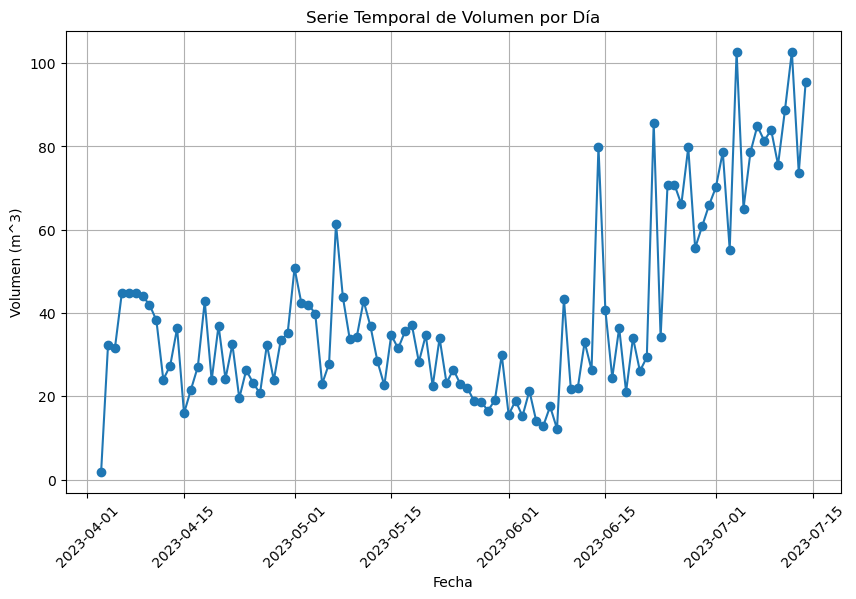

In [20]:
data_grouped = df_merged.groupby('date')['deltaVolumes'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(data_grouped['date'], data_grouped['deltaVolumes'], marker='o')
plt.xlabel('Fecha')
plt.ylabel('Volumen (m^3)')
plt.title('Serie Temporal de Volumen por Día')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [21]:
df_merged

,date,deltaVolumes,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2023-04-03,1.900,13.0,0.0,4.2,6.0,21.9,15.0,35.0,1.4,6.4,13.0,11.3,976.0,00,965.4,23
1,2023-04-04,32.394,16.9,0.0,9.7,6.0,24.1,15.0,4.0,2.5,9.2,11.0,11.7,970.5,24,964.8,04
2,2023-04-05,31.624,15.1,0.0,6.4,6.0,23.8,15.0,2.0,2.8,6.7,14.0,12.3,972.2,10,968.9,16
3,2023-04-06,44.853,16.4,0.0,6.9,6.0,25.8,17.0,35.0,1.9,6.4,17.0,12.3,971.5,10,968.8,14
4,2023-04-07,44.756,16.8,0.0,7.1,6.0,26.6,15.0,18.0,1.4,7.5,23.0,12.4,970.8,10,967.8,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-07-10,75.611,29.6,0.0,19.0,5.0,40.1,16.0,28.0,1.7,9.7,15.0,14.2,974.7,08,970.1,20
99,2023-07-11,88.741,30.0,0.0,22.5,5.0,37.6,15.0,22.0,3.3,11.9,16.0,14.0,971.6,23,969.3,17
100,2023-07-12,102.755,26.5,0.0,19.0,5.0,34.0,15.0,26.0,3.1,9.2,17.0,13.4,973.0,11,970.6,02
101,2023-07-13,73.674,28.4,0.0,20.9,5.0,35.9,16.0,31.0,2.8,8.1,15.0,14.3,974.1,08,970.4,19


In [22]:
df_merged['NumMes'] = df_merged['date'].dt.month

# Crea una columna para el día de la semana (1-7, donde 1 es Lunes y 7 es Domingo)
df_merged['DiaSem'] = df_merged['date'].dt.dayofweek + 1

df_merged = df_merged[['NumMes', 'DiaSem'] + [col for col in df_merged.columns if col not in ['NumMes', 'DiaMes']]]

df_merged = df_merged.drop(columns=['date'])

In [23]:
df_merged['previous_deltaVolumes'] = df_merged['deltaVolumes'].shift(1)

df_merged.dropna(inplace=True)

df_merged

,NumMes,DiaSem,deltaVolumes,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin,DiaSem,previous_deltaVolumes
1,4,2,32.394,16.9,0.0,9.7,6.0,24.1,15.0,4.0,2.5,9.2,11.0,11.7,970.5,24,964.8,04,2,1.900
2,4,3,31.624,15.1,0.0,6.4,6.0,23.8,15.0,2.0,2.8,6.7,14.0,12.3,972.2,10,968.9,16,3,32.394
3,4,4,44.853,16.4,0.0,6.9,6.0,25.8,17.0,35.0,1.9,6.4,17.0,12.3,971.5,10,968.8,14,4,31.624
4,4,5,44.756,16.8,0.0,7.1,6.0,26.6,15.0,18.0,1.4,7.5,23.0,12.4,970.8,10,967.8,17,5,44.853
5,4,6,44.912,18.2,0.0,8.2,6.0,28.3,15.0,18.0,1.1,7.8,2.0,12.1,971.5,24,968.7,02,6,44.756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,7,1,75.611,29.6,0.0,19.0,5.0,40.1,16.0,28.0,1.7,9.7,15.0,14.2,974.7,08,970.1,20,1,83.985
99,7,2,88.741,30.0,0.0,22.5,5.0,37.6,15.0,22.0,3.3,11.9,16.0,14.0,971.6,23,969.3,17,2,75.611
100,7,3,102.755,26.5,0.0,19.0,5.0,34.0,15.0,26.0,3.1,9.2,17.0,13.4,973.0,11,970.6,02,3,88.741
101,7,4,73.674,28.4,0.0,20.9,5.0,35.9,16.0,31.0,2.8,8.1,15.0,14.3,974.1,08,970.4,19,4,102.755


In [24]:
column_names = df_merged.columns.tolist()

if "deltaVolumes" in column_names:
    column_names.remove("deltaVolumes")

column_names.append("deltaVolumes")

df_merged = df_merged[column_names]
df_merged['deltaVolumes'] = df_merged['deltaVolumes'].astype(float)
df_merged['horaPresMax'] = df_merged['horaPresMax'].astype(float)
df_merged['horaPresMin'] = df_merged['horaPresMin'].astype(float)

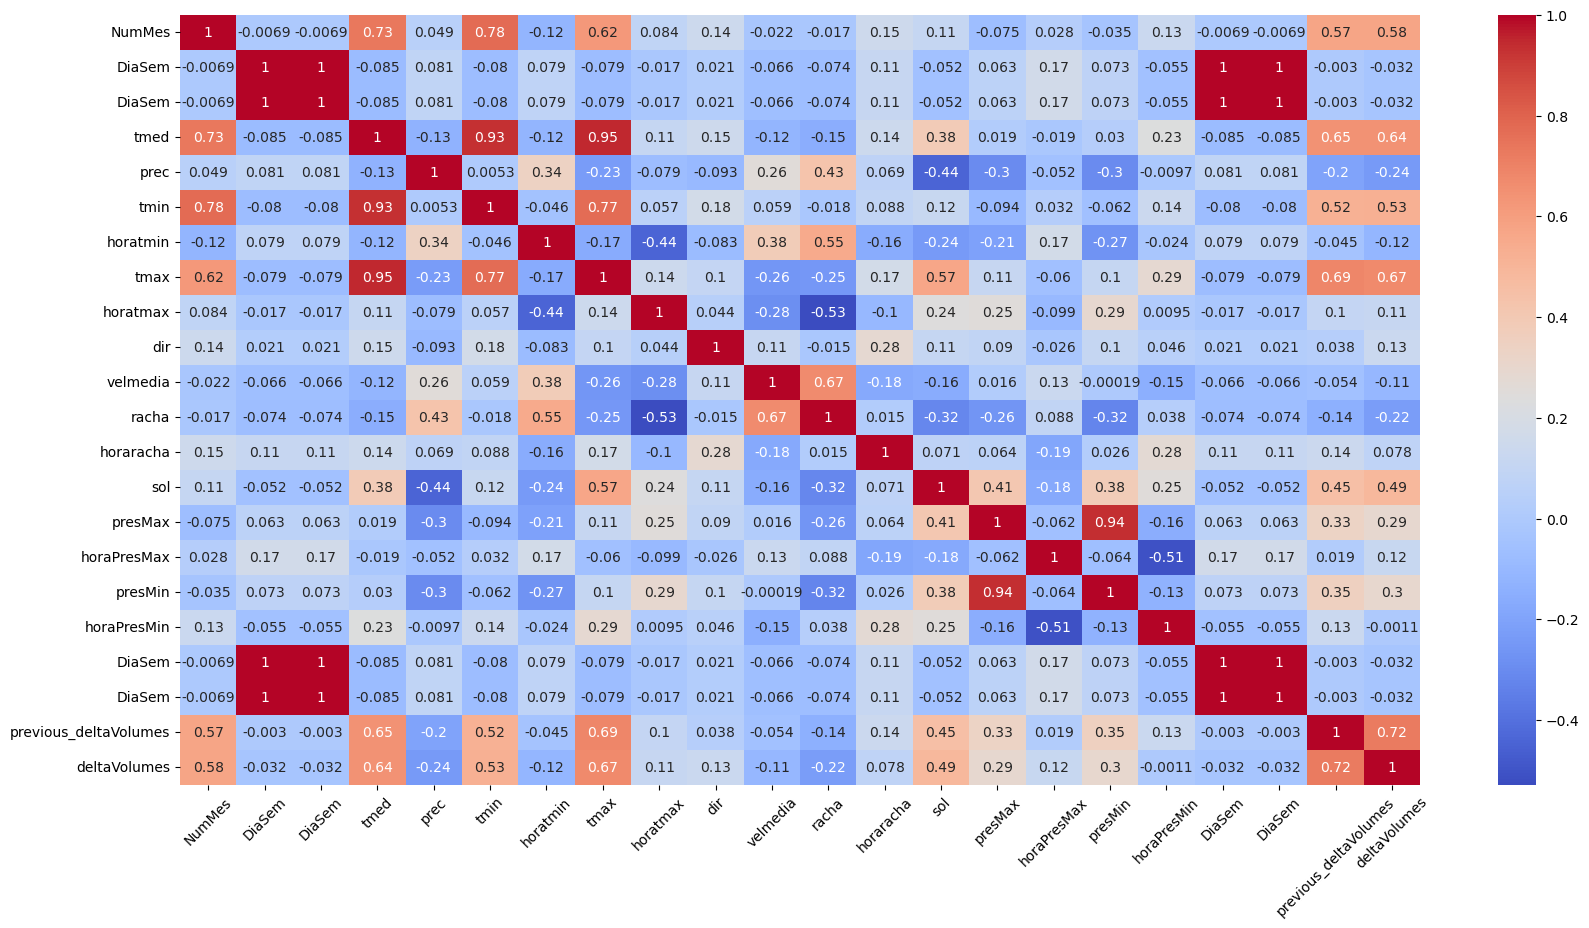

In [25]:
corr_matrix = df_merged.corr()

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [26]:
df_merged.columns

Index(['NumMes', 'DiaSem', 'DiaSem', 'tmed', 'prec', 'tmin', 'horatmin',
       'tmax', 'horatmax', 'dir', 'velmedia', 'racha', 'horaracha', 'sol',
       'presMax', 'horaPresMax', 'presMin', 'horaPresMin', 'DiaSem', 'DiaSem',
       'previous_deltaVolumes', 'deltaVolumes'],
      dtype='object')

In [27]:
# Separar las características y la variable objetivo
X = df_merged[['NumMes', 'tmed', 'tmin', 'tmax',
       'horatmax', 'dir', 'velmedia', 'racha', 'sol', 'presMax',
       'horaPresMax', 'presMin', 'previous_deltaVolumes']]

y = df_merged['deltaVolumes']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Crear el modelo de Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor()

# Ajustar el modelo a los datos de entrenamiento
gb_regressor.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = gb_regressor.predict(X_test)

# Calcular el coeficiente de determinación R2 en los datos de prueba
r2 = r2_score(y_test, y_pred)
print("Coeficiente de determinación R2:", r2)

# Calcular el error cuadrático medio en los datos de prueba
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)

Coeficiente de determinación R2: 0.5286568778651752
Error cuadrático medio: 181.57655006454192


In [29]:
df_Rand = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=10)
df_Rand.fit(X_train, y_train)
val_Rand_predictions = df_Rand.predict(X_test)
# Calcular el coeficiente de determinación R2 en los datos de prueba
r2 = r2_score(y_test, val_Rand_predictions)
print("Coeficiente de determinación R2:", r2)

# Calcular el error cuadrático medio en los datos de prueba
mse = mean_squared_error(y_test, val_Rand_predictions)
print("Error cuadrático medio:", mse)

Coeficiente de determinación R2: 0.5443090921580884
Error cuadrático medio: 175.54681304556163


In [30]:
df_Reg = LinearRegression()
df_Reg.fit(X_train, y_train)
val_Reg_predictions = df_Reg.predict(X_test)

# Calcular el coeficiente de determinación R2 en los datos de prueba
r2 = r2_score(y_test, val_Reg_predictions)
print("Coeficiente de determinación R2:", r2)

# Calcular el error cuadrático medio en los datos de prueba
mse = mean_squared_error(y_test, val_Reg_predictions)
print("Error cuadrático medio:", mse)

Coeficiente de determinación R2: 0.3449204077521708
Error cuadrático medio: 252.3577555121799


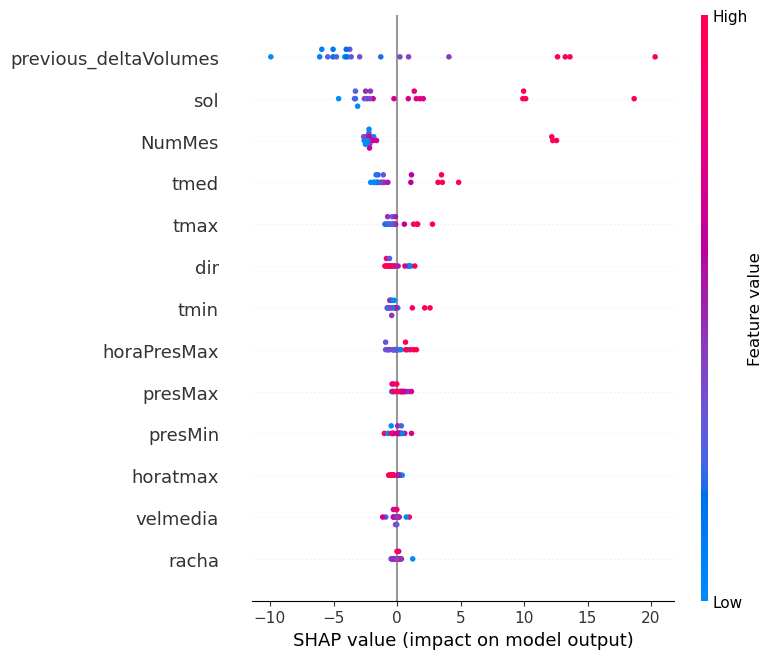

In [31]:
explainer = shap.Explainer(df_Rand, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [33]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

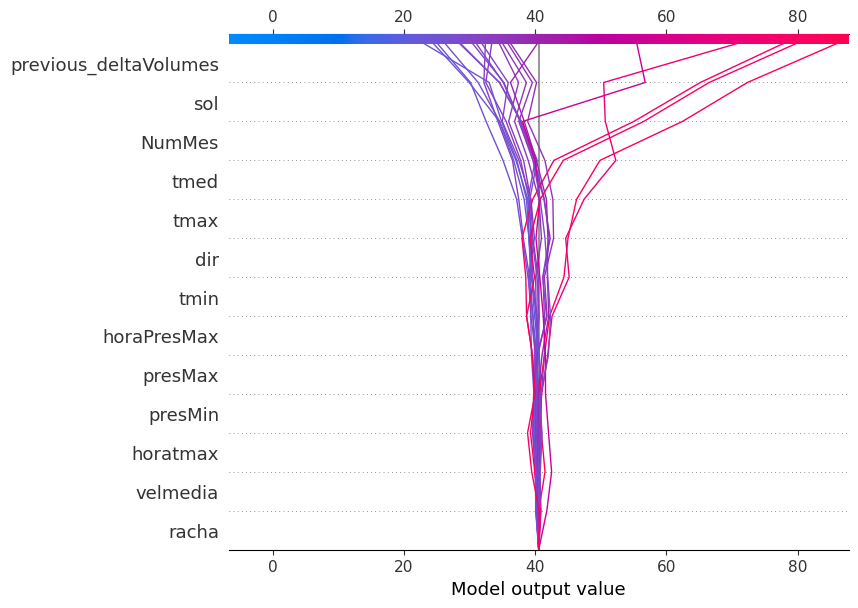

In [34]:
shap.decision_plot(explainer.expected_value, shap_values, X_test)